In [1]:
## import stuff

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import tensorflow as tf
import random
import matplotlib.pyplot as plt

%matplotlib inline
import os
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import gc 

In [2]:
gc.collect()

132

In [3]:
## import the tablular data info

data_train = pd.read_csv('~/Downloads/siim-isic-melanoma-classification/train.csv')
data_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
## sex and anatomical_Site categorical
data_train.sex = np.where(data_train.sex == 'female', 1, 0)
data_train = pd.get_dummies(data_train, columns = ['anatom_site_general_challenge'])
data_train.head()

,image_name,patient_id,sex,age_approx,diagnosis,benign_malignant,target,anatom_site_general_challenge_head/neck,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_upper extremity
0,ISIC_2637011,IP_7279968,0,45.0,unknown,benign,0,1,0,0,0,0,0
1,ISIC_0015719,IP_3075186,1,45.0,unknown,benign,0,0,0,0,0,0,1
2,ISIC_0052212,IP_2842074,1,50.0,nevus,benign,0,0,1,0,0,0,0
3,ISIC_0068279,IP_6890425,1,45.0,unknown,benign,0,1,0,0,0,0,0
4,ISIC_0074268,IP_8723313,1,55.0,unknown,benign,0,0,0,0,0,0,1


In [5]:
100*(data_train.target.sum()/data_train.target.count())

1.762965646320111

## look at image data

In [6]:
os.chdir('../../Downloads/siim-isic-melanoma-classification/')
data_dir = 'jpeg/train/'
train_files = os.listdir(data_dir)

In [7]:
len(train_files)

33126

In [8]:
## dict of the image and its target
data_train.image_name = data_train.image_name.astype(str) + str('.jpg')
target_dict = pd.Series(data_train.target.values, index = data_train.image_name).to_dict()

In [9]:
## list of melanoma and not melanoma images
ls_melanoma = []
ls_no_melanoma = []
for k,v in target_dict.items():
    if v == 1:
        ls_melanoma.append(k)
    if v == 0:
        ls_no_melanoma.append(k)

In [10]:
random.choice(ls_no_melanoma)

'ISIC_7305051.jpg'

In [11]:
gc.collect()

60

In [12]:
## lets pick 200 melanoma/not-melanoma images each

sample_mela = random.sample(ls_melanoma, 200)
sample_no_mela = random.sample(ls_no_melanoma, 200)

## Body Hair Analysis - blackhat filter

In [13]:
## read in and convert an image to numpy tensor
def nptensor(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path)
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    return input_arr

## hair_remove takes an tensor and returns an tensor
## can directly be passed as arg to image data generator
def hair_remove(input_arr):
    import cv2
    kernel = cv2.getStructuringElement(1,(17,17)) 
    
    ## convert rgb tensor to bgr tensor for cv2
    input_arr_swap = (input_arr[..., ::-1]).astype(np.uint8)
    
    ## black n white
    input_image_gray = cv2.cvtColor(input_arr_swap, cv2.COLOR_RGB2GRAY)
    # Applying the Black-Hat operation 
    tophat_img = cv2.morphologyEx(input_image_gray
                                  , cv2.MORPH_BLACKHAT
                                  , kernel)
    ## threshold the image to increase the hair intensity
    ret,thresh_img = cv2.threshold(tophat_img,10,255,cv2.THRESH_BINARY)
    ## remove hair 
    pre_out = cv2.inpaint(input_arr_swap,thresh_img,1,cv2.INPAINT_TELEA)
    ## convert back to rgb 
    out = cv2.cvtColor(pre_out, cv2.COLOR_BGR2RGB)
    return (out/255).astype(np.float32)

jpeg/train/ISIC_4150885.jpg


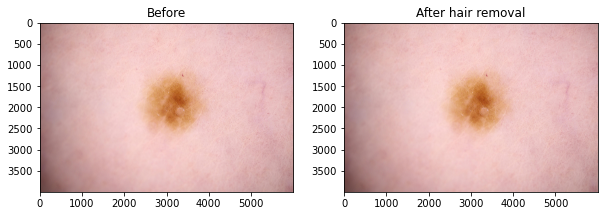

In [14]:
pic = os.path.join(data_dir, random.choice(ls_no_melanoma))
print(pic)
img = mpimg.imread(pic)
img_arr = nptensor(pic)
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Before')
plt.subplot(1, 2, 2)
plt.imshow(hair_remove(img_arr))
plt.title('After hair removal')
plt.show()

jpeg/train/ISIC_1132496.jpg


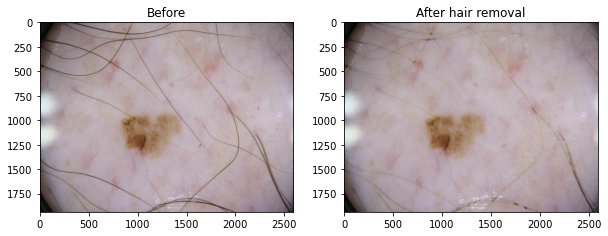

In [15]:
## fixing image to show one example of hair removal
## Note: image with melanoma
pic = os.path.join(data_dir, 'ISIC_1132496.jpg')
print(pic)
img = mpimg.imread(pic)
img_arr = nptensor(pic)
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Before')
plt.subplot(1, 2, 2)
plt.imshow(hair_remove(img_arr))
plt.title('After hair removal')
plt.show()

## Directory Re-Structuring

In [ ]:
## make new directory
! mkdir 'train_w_class'

## create class directories
! mkdir 'train_w_class/no_melanoma'
! mkdir 'train_w_class/melanoma'
melanoma_dir = 'train_w_class/melanoma'
no_melanoma_dir = 'train_w_class/no_melanoma'

## move images to class specific directories

## creating no melanoma dir
for i in ls_no_melanoma:
    shutil.copy(os.path.join('jpeg/train/', i), os.path.join(no_melanoma_dir, i))
    

## creating melanoma dir
for i in ls_melanoma:
    shutil.copy(os.path.join('jpeg/train/', i), os.path.join(melanoma_dir, i))

## dummy directory - 400 images for overfit to test model init

In [ ]:
## make new directory
! mkdir 'train_w_class_dummy'

## create class directories
! mkdir 'train_w_class_dummy/no_melanoma'
! mkdir 'train_w_class_dummy/melanoma'
melanoma_dir = 'train_w_class_dummy/melanoma'
no_melanoma_dir = 'train_w_class_dummy/no_melanoma'

## move images to class specific directories

## creating no melanoma dir
for i in sample_no_mela:
    shutil.copy(os.path.join('jpeg/train/', i), os.path.join(no_melanoma_dir, i))
    

## creating melanoma dir
for i in sample_mela:
    shutil.copy(os.path.join('jpeg/train/', i), os.path.join(melanoma_dir, i))

## Image loading & Augmentation

- use image generator
- passing the custom preprocessing to remove hair in images - this way dont have to save on disk space as in notebook 1

In [16]:
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

## some additional data augmentation
training_datagen = ImageDataGenerator(
#    rescale = 1./255,
#     rotation_range=40 
#     zoom_range=0.2
     horizontal_flip=True
    , preprocessing_function=hair_remove
)

## utilize the new directory structure to infer classes
train_generator = training_datagen.flow_from_directory(
    'train_w_class_dummy'
    , target_size=(512,512)
    , class_mode='binary'
    , batch_size=20
)

Found 400 images belonging to 2 classes.


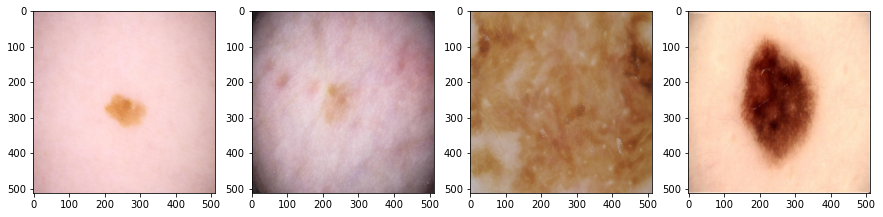

In [17]:
## look at few example
for x, y in train_generator:
    fig = plt.figure(figsize=(15,5))
    plt.subplot(1, 4, 1)
    plt.imshow(x[0])
    plt.subplot(1, 4, 2)
    plt.imshow(x[1])
    plt.subplot(1, 4, 3)
    plt.imshow(x[2])
    plt.subplot(1, 4, 4)
    plt.imshow(x[3])
    plt.show()
    break

In [18]:
train_generator.class_indices

{'melanoma': 0, 'no_melanoma': 1}

## Transfer Learning model - ResNet50 - Init

In [19]:
from tensorflow.keras.applications.resnet50 import ResNet50

transf_model = ResNet50(weights='imagenet'
                        , input_shape = (512,512,3)
                        , include_top = False)

for layer in transf_model.layers:
    layer.trainable = False
    
transf_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [20]:
## grab the last layer 
last_layer = transf_model.get_layer('conv5_block3_out')
print(last_layer.output_shape)

(None, 16, 16, 2048)


In [21]:
freeze_output = last_layer.output

In [24]:
## flatten - fully connected layer w/ dropout - output prediction
x = tf.keras.layers.Flatten()(freeze_output)
## add the sex, age and anatomical-site to the output of the resnet for further processing 
# FC layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)
## Add a layer
x = tf.keras.layers.Dense(512, activation='relu')(x)
# final layer for classification
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)  

In [25]:
model = tf.keras.Model(transf_model.input, x)
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(lr=0.0001)
              , loss = 'binary_crossentropy'
              , metrics = ['accuracy', tf.keras.metrics.AUC()])

In [26]:
history = model.fit(
    train_generator
    , steps_per_epoch = 20
    , epochs = 5
    , verbose = 1)

Epoch 1/5
20/20 [==============================] - 352s 18s/step - loss: 21.4356 - accuracy: 0.5000 - auc_1: 0.5060
Epoch 2/5
20/20 [==============================] - 346s 17s/step - loss: 6.3038 - accuracy: 0.5225 - auc_1: 0.5196
Epoch 3/5
20/20 [==============================] - 344s 17s/step - loss: 4.4823 - accuracy: 0.5225 - auc_1: 0.4997
Epoch 4/5
20/20 [==============================] - 363s 18s/step - loss: 3.6552 - accuracy: 0.4800 - auc_1: 0.4937
Epoch 5/5
20/20 [==============================] - 350s 17s/step - loss: 3.1700 - accuracy: 0.4725 - auc_1: 0.4861


In [27]:
## loss is decreasing - model construct working